In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import pickle


import psutil
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2,3,4,5,6,7,8,9,10])

os.chdir(r'H:\all\RL_Shrinkage_2024')
from helpers import helper_functions as hf
from ONE_YR_long_only.NonLinear_Shrinkage import regression_evaluation_funcs as re_hf
from helpers import eval_function_new



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\traitlets\con

In [2]:
PF_SIZE = 500


base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
# IMPORT SHRK DATASETS
pf_size = PF_SIZE  # DONT CHANGE HERE!!
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR_long_only\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR_long_only\preprocessing\rets_permnos_1Y\returns_full_1Y_p{pf_size}.pickle")


fixed_shrk_name = 'cov1Para'
opt_shrk_name = 'cov1Para'
with open(rf"{base_folder_path}\ONE_YR_long_only\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR_long_only\preprocessing\training_dfs\PF{pf_size}\{opt_shrk_name}_factor-1.0_p{pf_size}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)

with open(rf"{base_folder_path}\ONE_YR_long_only\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_rawres_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    rawres_fixed_shrk_data = pickle.load(f)

# IMPORT FACTORS DATA AND PREPARE FOR FURTHER USE
factor_path = fr"{base_folder_path}\helpers"
factors = pd.read_csv(factor_path + "/all_factors.csv")
factors = factors.pivot(index="date", columns="name", values="ret")

# as our shrk data starts from 1980-01-15 our factors data should too
start_date = str(optimal_shrk_data['date'].iloc[0])
start_date = start_date[0:4] + '-' + start_date[4:6] + "-" + start_date[6:]
start_idx = np.where(factors.index == start_date)[0][0]
factors = factors.iloc[start_idx:start_idx+fixed_shrk_data.shape[0], :]

cov1para_shrk = optimal_shrk_data['shrk_factor'].values[5040:]

len_train = 5040
end_date = fixed_shrk_data.shape[0]
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]

In [3]:
sd=rawres_fixed_shrk_data.loc[:, 0.00].iloc[5040:].std()*np.sqrt(252)*100

av=rawres_fixed_shrk_data.loc[:, 0.00].iloc[5040:].mean()*(252)*100

ir=av/sd

print(f"Res for SAMPLE: AV: {av}, SD: {sd}, IR: {ir}")

Res for SAMPLE: AV: 9.294607665257546, SD: 12.099993419361219, IR: 0.7681498115846269


In [4]:
optimal_shrk_data['shrk_factor'].astype(np.float64).round(2)
x = np.diag(rawres_fixed_shrk_data.loc[:, optimal_shrk_data['shrk_factor'].astype(np.float64).round(2)])[5040:]

sd = x.std() * np.sqrt(252) * 100
av = x.mean() * (252) * 100
ir = av/sd

print(f" AV: {av} \n SD: {sd} \n IR: {ir}")

 AV: 9.574585595434982 
 SD: 12.134814889582799 
 IR: 0.7890178533876392


In [5]:
all_res = rawres_fixed_shrk_data.rolling(window=21, min_periods=1).std().bfill()*np.sqrt(252) * 100
all_factors = fixed_shrk_data.iloc[:, 2:].columns.astype(float).values
Y = all_res.idxmin(axis=1).values.astype(float)

"""
Y = Y[list(range(0, all_res.shape[0], 21))]
Y = np.repeat(Y, 21)
"""

#Y = a

opt_values = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(0.15, 21))

# old: Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
Y = np.array(re_hf.map_factors_to_preds(Y, all_factors))

opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, all_res.idxmin(axis=1).values])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values


ROLL_WINDOW = 1
ROLL_WINDOW_INPUTS = 252
rolling_opt = pd.Series(opt_values).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values

Y = pd.Series(Y).rolling(window=1, min_periods=1).mean().astype(np.int64).values
opt_values = pd.Series(opt_values).rolling(window=1, min_periods=1).mean().astype(np.int64).values



In [6]:
opt_new = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_new = np.insert(arr=opt_new, obj=0, values=np.repeat(0.15, 21))
opt_new = opt_new[list(range(0, opt_new.shape[0], 21))]
opt_new = np.repeat(opt_new, 21)

ROLL_WINDOW = 1
ROLL_WINDOW_INPUTS = 252
rolling_opt_new = pd.Series(opt_new).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values

In [7]:


params = {
'pf_size' : pf_size,
'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': False,
'include_factors': False,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
    'additional_inputs' : [opt_v3, rolling_opt, rolling_opt2, optimal_shrk_data['shrk_factor'].values.astype(np.float64)*100]  
}

X = re_hf.load_additional_train_data(**params)

In [8]:
TRAIN_SPECIAL = False

if TRAIN_SPECIAL is True:
    print("##########\n")
    print("TRAINING WITH WEIGTED AVG OF c1p and ORACLE Y")
    Y = optimal_shrk_data['shrk_factor'].values.astype(np.float64)*100*0.5 + Y*0.5

else:
    print("##########\n")
    print("TRAINING WITH ORACLE Y ONLY")
    

##########

TRAINING WITH ORACLE Y ONLY


In [9]:
from sklearn.linear_model import ElasticNet

def general_single_output_ElasticNet_Lagged_WEIGHTED(X, Y, len_train, single_train=False, expanding=False, train_size=None, model_params={}, sample_weight=None):
    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else:  # TRAINING
            if single_train == False:
                if expanding == False:
                    w = sample_weight[len_train - train_size + 21*i : len_train + 21*(i-1)]
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1)]
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1)]
                regr = ElasticNet(random_state=123, **model_params)
                regr = regr.fit(x_train, y_train, sample_weight=w)
            else:
                if i == 0:
                    w = sample_weight[len_train - train_size + 21 * i: len_train + 21 * (i - 1)]
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1)]
                    regr = ElasticNet(random_state=123, **model_params)
                    regr = regr.fit(x_train, y_train, sample_weight=w)
            ## TRAINING DONE
            x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))
            preds = regr.predict(x_test)

            #preds = int(np.round(preds, 0))

            #print(f"fitted model in iteration {i} out of {5313//21}")
            model_predictions.append(preds)



### WEIGHTED ELASTIC NET

In [10]:
weight_map = dict([ (i-1, 1/(np.log(i+1)) ) for i in range(1, all_factors.shape[0]+1, 1)])
weights = list(map(weight_map.get, Y))

# px.line(weight_map.values())

np.float64(12.134924561281942)

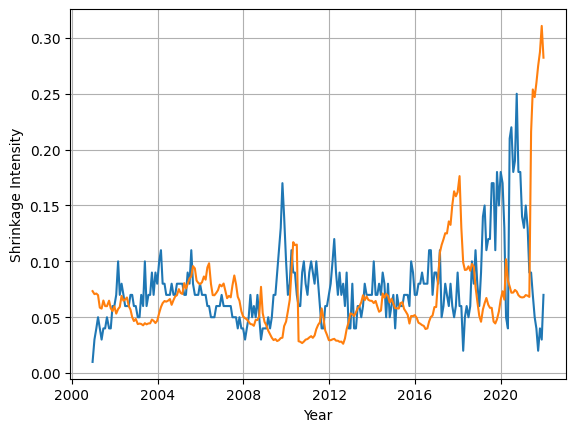

In [11]:
weight_map = dict([ (i-1, 1/(np.log(i+1)) ) for i in range(1, all_factors.shape[0]+1, 1)])
weights = list(map(weight_map.get, Y))

res = general_single_output_ElasticNet_Lagged_WEIGHTED(X=X, Y=Y, len_train=5040, sample_weight=np.array(weights))

mapped_res = np.round(res/100, 2)
mapped_res = [i if i > 0 else 0 for i in mapped_res]

res_df = pd.DataFrame({"ElasticNet_CVC": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

res = general_single_output_ElasticNet_Lagged_WEIGHTED(X=X, Y=Y, len_train=5040, sample_weight=np.array(weights))
res = np.round(res/100, 2)

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

### Cross Validation

In [12]:
from sklearn.linear_model import ElasticNet
def general_single_output_ElasticNet_Lagged_CrossValidation_Weighted(X, Y, len_train, single_train=False, expanding=False, train_size=None, model_params={}, sample_weight=None):
    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else:  # TRAINING
            if single_train == False:
                if expanding == False:
                    w = sample_weight[len_train - train_size + 21*i : len_train + 21*(i-1)]
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), ]
                else:
                    w = sample_weight[len_train - train_size + 21*i : len_train + 21*(i-1)]
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), ]
                regr = ElasticNet(random_state=123, **model_params)
                regr = regr.fit(x_train, y_train, sample_weight=w)
            else:
                if i == 0:
                    w = sample_weight[len_train - train_size + 21 * i: len_train + 21 * (i - 1)]
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), ]
                    regr = ElasticNet(random_state=123, **model_params)
                    regr = regr.fit(x_train, y_train, sample_weight=w)
            ## TRAINING DONE
            x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))
            preds = regr.predict(x_test)

            preds = np.round(preds, 0)
            model_predictions.append(preds)


def eval_model_outputs_cross_val(res, intensity_of_intensity_list, len_cv_train, len_train):
    res = [len(intensity_of_intensity_list)-1 if r > len(intensity_of_intensity_list) else r for r in res]
    res = [0 if r < 0 else r for r in res]

    Y_eval = rawres_fixed_shrk_data.iloc[len_cv_train:len_train]

    returns = np.diag(Y_eval.iloc[:, res])
    returns_sd = returns.std() * np.sqrt(252) * 100
    returns_means = returns.mean() * 252 * 100

    return returns_means, returns_sd

In [13]:
len_cv_train = int(len_train*0.8) 

train_x_cv = X[:len_cv_train]
train_y_cv = Y[:len_cv_train]

val_x = X[len_cv_train:len_train]
val_y = Y[len_cv_train:len_train]

In [20]:
TRAIN_WITH_CUSTOM_WEIGTHS = True

if not TRAIN_WITH_CUSTOM_WEIGTHS:
    weights = np.array([1 for i in range(Y.shape[0])])
    print("TRAINING WITH EQUAL WEIGHTS")
else:
    weight_map = dict([ (i-1, 1/(np.log(i+1)) ) for i in range(1, all_factors.shape[0]+1, 1)])
    weights = list(map(weight_map.get, Y))
    print("TRAINING WITH CUSTOM WEIGHTING: f(x) = 1/log(x+1)")

from sklearn.model_selection import ParameterGrid
model_params_grid = {
    "alpha": [0.5, 1.0, 1.5, 2.0, 5.0],
    "l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9],
    "max_iter": [500, 1000, 1500, 2000],
    "tol": [1e-3, 1e-4, 1e-5],
}
model_params_grid = list(ParameterGrid(model_params_grid))
intensity_of_intensity_list = all_res.columns
sds = []
for i, p in enumerate(model_params_grid):
    res = general_single_output_ElasticNet_Lagged_CrossValidation_Weighted(X=X[:len_train], Y=Y[:len_train], len_train=len_cv_train, model_params=p, sample_weight=weights)
    AV, SD = eval_model_outputs_cross_val(res, intensity_of_intensity_list, len_cv_train, len_train)
    sds.append(SD.round(3))
    if i%10 == 0:
        print(f"fitted model {i} / {len(model_params_grid)}")

TRAINING WITH CUSTOM WEIGHTING: f(x) = 1/log(x+1)
fitted model 0 / 300
fitted model 10 / 300
fitted model 20 / 300
fitted model 30 / 300
fitted model 40 / 300
fitted model 50 / 300
fitted model 60 / 300
fitted model 70 / 300
fitted model 80 / 300
fitted model 90 / 300
fitted model 100 / 300
fitted model 110 / 300
fitted model 120 / 300
fitted model 130 / 300
fitted model 140 / 300
fitted model 150 / 300
fitted model 160 / 300
fitted model 170 / 300
fitted model 180 / 300
fitted model 190 / 300
fitted model 200 / 300
fitted model 210 / 300
fitted model 220 / 300
fitted model 230 / 300
fitted model 240 / 300
fitted model 250 / 300
fitted model 260 / 300
fitted model 270 / 300
fitted model 280 / 300
fitted model 290 / 300


#### Evaluate best model on OOS data

np.float64(12.134117318774926)

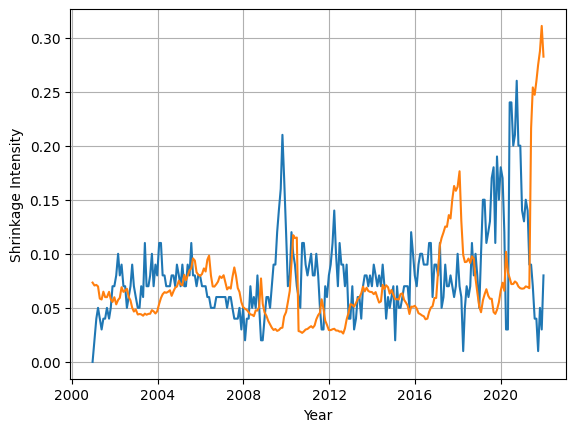

In [21]:
np.argmin(sds)
p_best = model_params_grid[np.argmin(sds)]
res = general_single_output_ElasticNet_Lagged_CrossValidation_Weighted(X=X, Y=Y, len_train=len_train, model_params=p_best, sample_weight=weights)
res = [r if r > 0 else 0 for r in res]
res = [r if r < all_factors.shape[0] else all_factors.shape[0]-1 for r in res]

mapped_res = np.array(re_hf.map_preds_to_factors(res, all_factors)).astype(float)
#mapped_res = [ round(i-0.25,2) if i-0.25 >= 0 else i for i in mapped_res ]
#r = eval_function_new.eval_fct_networkonly_1YR(mapped_res, rets_full, permnos, 0, val_indices_results)
#eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

res_df = pd.DataFrame({"ElasticNet_CVC": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

In [22]:
res = general_single_output_ElasticNet_Lagged_CrossValidation_Weighted(X=X, Y=Y, len_train=len_train, model_params=p_best, sample_weight=weights)

In [23]:
p_best

{'alpha': 0.5, 'l1_ratio': 0.75, 'max_iter': 500, 'tol': 0.001}

In [18]:
print("OOS L_RL RESULTS:")

sd = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100
av = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).mean()*252*100

print("av: ", av.round(2))
print("sd: ", sd.round(2))
print("ir: ", (av/sd).round(2))

OOS L_RL RESULTS:
av:  9.43
sd:  12.13
ir:  0.78


### Save OOS Results of Best model

In [277]:
dates = pd.to_datetime(permnos.index.values, format="%Y%m%d")

In [278]:
OUT_PATH = rf"H:\all\RL_Shrinkage_2024\ONE_YR_long_only\Linear_Shrinkage\results\p{PF_SIZE}"
oos_daily_rets = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res])
pd.Series(oos_daily_rets, index=dates[5040:]).to_csv(f"{OUT_PATH}/OOS_daily_returns.csv")

In [279]:
oos_daily_rets.std()*np.sqrt(252)*100

np.float64(12.757644910758161)

In [280]:
pd.read_csv(OUT_PATH + "/OOS_daily_returns.csv", index_col=0).values.reshape(-1,)

array([ 0.01114525, -0.00374505, -0.02000577, ...,  0.00107576,
        0.01835866,  0.01070893])

### For Best Model, 
- create grid with AV and SD with convex combinations of the best OOS fixed intensity 
- create our model with the same mean as best OOS fixed intensity

In [281]:
convex_combo_sd = []
convex_combo_av = []
convex_combo_daily_rets = []

OPT_OOS_FIXED_SHRK_DICT = {
    30: 0.13, 
    50: 0.2, 
    100: 0.23, 
    225: 0.24, 
    500: 0.24
    }

OPT_OOS_FIXED_SHRK = OPT_OOS_FIXED_SHRK_DICT[PF_SIZE]
OUT_PATH = rf"H:\all\RL_Shrinkage_2024\ONE_YR_long_only\Linear_Shrinkage\results\p{PF_SIZE}"

for a in list(range(0,11,1)):
    a = a/10   
    x = (np.round((mapped_res * (1-a) + OPT_OOS_FIXED_SHRK * a), 2))
    daily_rets = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, x])   
    convex_combo_daily_rets.append(daily_rets)                  
    convex_combo_av.append(daily_rets.mean() * 252 * 100)
    convex_combo_sd.append(daily_rets.std()* np.sqrt(252) * 100)

convex_combo_av = pd.DataFrame(convex_combo_av, index=[i/10 for i in range(0,11)], columns=[PF_SIZE]).T
convex_combo_sd = pd.DataFrame(convex_combo_sd, index=[i/10 for i in range(0,11)], columns=[PF_SIZE]).T
convex_combo_daily_rets = pd.DataFrame(convex_combo_daily_rets, index=[i/10 for i in range(0,11)]).T

In [282]:
x = np.round(mapped_res * (OPT_OOS_FIXED_SHRK/np.mean(mapped_res)), 2)
x = [x if x<1 else 1 for x in x]
daily_rets = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, x])
convex_combo_av['re-scaled'] = daily_rets.mean() * 252 * 100
convex_combo_sd['re-scaled'] = daily_rets.std()* np.sqrt(252) * 100
convex_combo_daily_rets['re-scaled'] = daily_rets

convex_combo_av.to_csv(OUT_PATH + "/Convex_Combo_AV.csv")
convex_combo_sd.to_csv(OUT_PATH + "/Convex_Combo_SD.csv")
convex_combo_daily_rets.to_csv(OUT_PATH + "/Convex_Combo_DailyReturns.csv")

In [283]:
pd.read_csv(OUT_PATH + "/Convex_Combo_SD.csv", index_col=0)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,re-scaled
225,12.757645,12.770578,12.781166,12.799209,12.812991,12.827122,12.844946,12.86579,12.885095,12.903348,12.928149,12.894044


### save oralce and shrinkage intensities of model 

In [284]:
### get oracle
OOS_Rebdates_indexer = list(range(0, 5313, 21))
oracle_min_idx = all_res.iloc[5040:].iloc[OOS_Rebdates_indexer].idxmin(axis=1).astype(np.float64)
oracle_min_idx_repeated = np.repeat(oracle_min_idx, 21).values
oracle_daily_oos_rets = np.diag(rawres_fixed_shrk_data.iloc[5040:, ].loc[:, oracle_min_idx_repeated])

In [285]:
pd.Series(mapped_res, dtype=np.float64, index=dates[5040:]).to_csv(OUT_PATH + f"/oos_linear_model_intensity_p{PF_SIZE}.csv")
pd.Series(oracle_min_idx_repeated, index=dates[5040:]).to_csv(OUT_PATH + f"/oos_linear_oracle_intensity_p{PF_SIZE}.csv")
pd.Series(oracle_daily_oos_rets, index=dates[5040:]).to_csv(OUT_PATH + f"/oos_linear_oracle_dailyrets_p{PF_SIZE}.csv")

save intensities as one csv once everything is ran

In [286]:
res_path = r"H:\all\RL_Shrinkage_2024\ONE_YR_long_only\Linear_Shrinkage\results"
for MODEL in ("model", "oracle"):
    all_intensities = []
    for pf_size in [30,50,100,225,500]:
        x = pd.read_csv(res_path + f"\\p{pf_size}\\oos_linear_{MODEL}_intensity_p{pf_size}.csv", index_col=0)
        all_intensities.append(x)


    all_intensities = pd.concat(all_intensities, axis=1)
    all_intensities.columns = [30,50,100,225,500]
    (all_intensities.iloc[list(range(0, all_intensities.shape[0], 21))]).to_csv(res_path + f"//oos_linear_{MODEL}_intensity_rebdates_full.csv")

also save base c1p shrinkage intensities

In [287]:
all_intensities = []
for pf_size in [30, 50, 100, 225, 500]:
    with open(rf"{base_folder_path}\ONE_YR_long_only\preprocessing\training_dfs\PF{pf_size}\{opt_shrk_name}_factor-1.0_p{pf_size}.pickle", 'rb') as f:
        optimal_shrk_data = pickle.load(f)
    cov1para_shrk = optimal_shrk_data['shrk_factor']
    cov1para_shrk.index = dates
    cov1para_shrk = cov1para_shrk.iloc[5040:]
    all_intensities.append(cov1para_shrk)

all_intensities = pd.concat(all_intensities, axis=1)
all_intensities.columns = [30,50,100,225,500]
(all_intensities.iloc[list(range(0, all_intensities.shape[0], 21))]).to_csv(res_path + f"//oos_linear_cov1Para_intensity_rebdates_full.csv")

save results

In [291]:
res_path = r"H:\all\RL_Shrinkage_2024\ONE_YR_long_only\Linear_Shrinkage\results"
all_model_oos_returns = []
for pf_size in [30, 50, 100, 225, 500]:
    x = pd.read_csv(res_path + f"\\p{pf_size}\\OOS_daily_returns.csv", index_col=0)
    all_model_oos_returns.append(x)


all_model_oos_returns = pd.concat(all_model_oos_returns, axis=1)
all_model_oos_returns.columns = [30,50,100,225,500]

all_model_oos_returns.to_csv(res_path + "\\model_linear_daily_returns.csv")

In [290]:
all_model_oos_returns

,30,50,100,225,500
2000-12-18,0.006390,0.013396,0.009349,0.011145,0.018455
2000-12-19,-0.007266,-0.004763,-0.006617,-0.003745,-0.001149
2000-12-20,-0.026163,-0.028435,-0.028009,-0.020006,-0.016299
2000-12-21,-0.002138,-0.008447,-0.002612,0.003914,0.007072
2000-12-22,0.019641,0.004197,0.015256,0.013324,0.009332
...,...,...,...,...,...
2022-01-25,-0.002263,-0.003419,-0.000146,-0.007122,-0.009582
2022-01-26,-0.002442,-0.011920,-0.010546,-0.011602,-0.013343
2022-01-27,0.004017,0.004296,0.002735,0.001076,0.002527
2022-01-28,0.015970,0.021319,0.017972,0.018359,0.017054
